# Fine-Tuning StableDiffusion XL with DreamBooth

### Stable Diffusion XL Model

First, we import the classes and libraries we need to run the notebook.

In [1]:
import torch
from diffusers import StableDiffusionXLPipeline, DiffusionPipeline

Next, from the Hugging Face `diffusers` library, we create a `StableDiffusionXLPipeline` object from the SDXL base model. 

In [2]:
pipe = StableDiffusionXLPipeline.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16, variant="fp16", use_safetensors=True
)
pipe.to("cuda")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

StableDiffusionXLPipeline {
  "_class_name": "StableDiffusionXLPipeline",
  "_diffusers_version": "0.28.0.dev0",
  "_name_or_path": "stabilityai/stable-diffusion-xl-base-1.0",
  "feature_extractor": [
    null,
    null
  ],
  "force_zeros_for_empty_prompt": true,
  "image_encoder": [
    null,
    null
  ],
  "scheduler": [
    "diffusers",
    "EulerDiscreteScheduler"
  ],
  "text_encoder": [
    "transformers",
    "CLIPTextModel"
  ],
  "text_encoder_2": [
    "transformers",
    "CLIPTextModelWithProjection"
  ],
  "tokenizer": [
    "transformers",
    "CLIPTokenizer"
  ],
  "tokenizer_2": [
    "transformers",
    "CLIPTokenizer"
  ],
  "unet": [
    "diffusers",
    "UNet2DConditionModel"
  ],
  "vae": [
    "diffusers",
    "AutoencoderKL"
  ]
}

Let's use the SDXL model to generate an image. 

  0%|          | 0/50 [00:00<?, ?it/s]

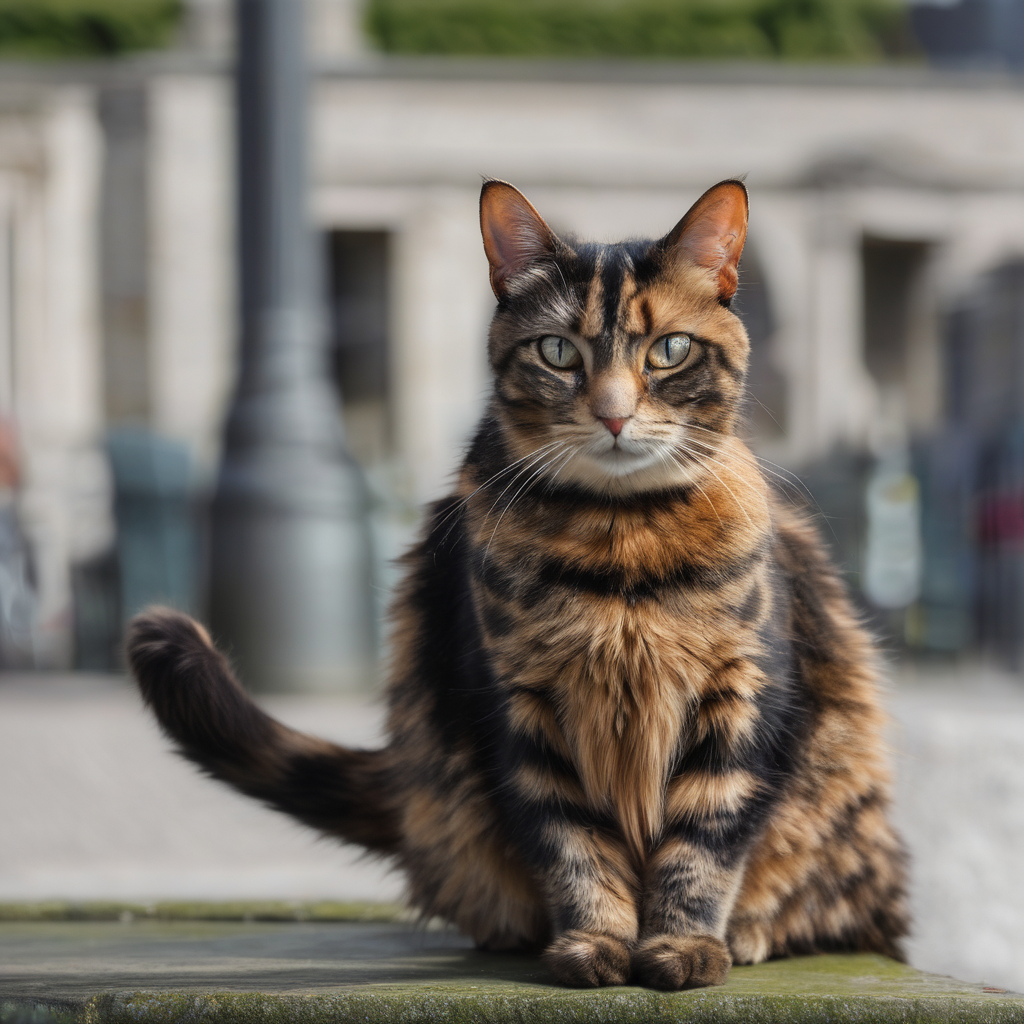

In [10]:
prompt = "realistic photo of tortoiseshell cat in Dun Laoghaire, Ireland"
image = pipe(prompt=prompt).images[0]

image


✅ Try using the SDXL model to generate some other images by editing the text in the first line of the cell above. 


## Fine-Tuning the model with DreamBooth

Fine-Tuning is used to train an existing Machine Learning Model, given new information. In our case, we want to teach the SDXL model about my cat. This will allow us to create a more accurate image of her every time!

[DreamBooth](https://arxiv.org/abs/2208.12242) provides a way to fine-tune a text-to-image model using only a few images. Let's use this to tune our SDXL Model so that it knows about Toy Jensen!

I have added 8 photos of my cat Elsa inside my-data folder - here's an example:

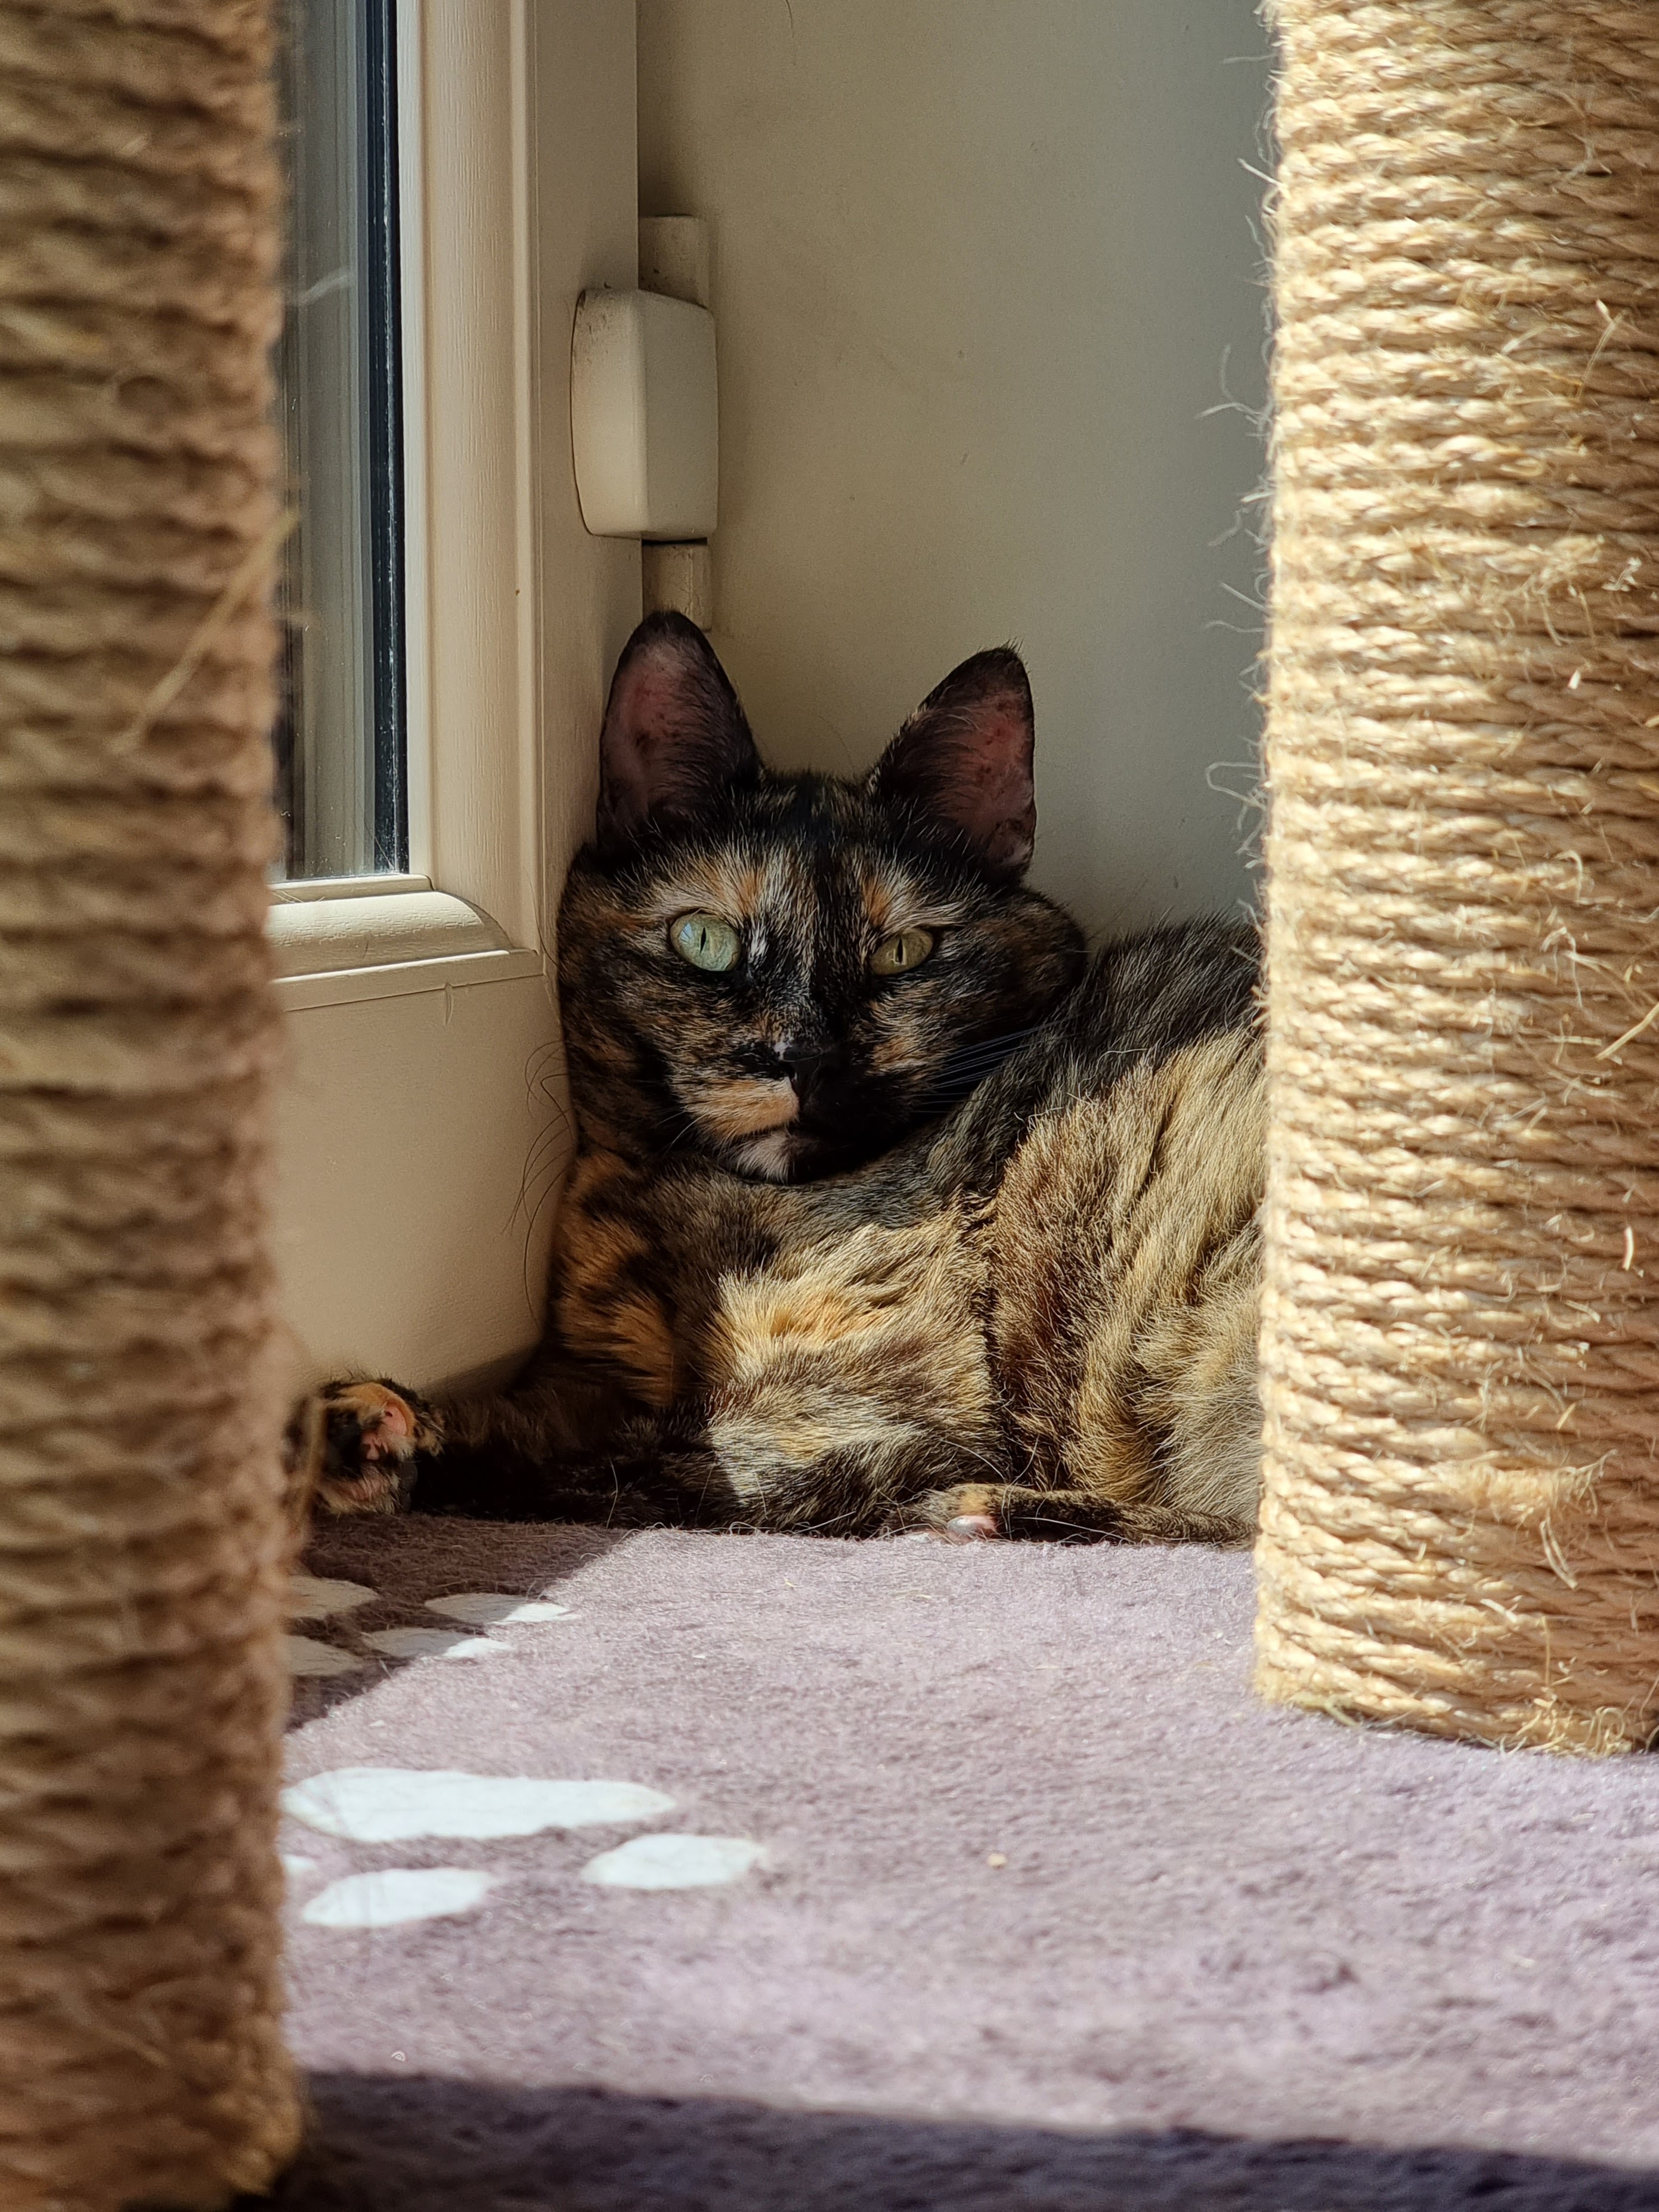

In [6]:
from IPython.display import Image, display

display(Image(filename='../data/my-data/20230613_144344.jpg'))

Now we can use Hugging Face and DreamBooth to fine-tune this model. To do this we create a config, then specify some flags like an instance prompt, a resolution and a number of training steps for the fine-tuning algorithm to run. 

In [9]:
from accelerate.utils import write_basic_config

write_basic_config()

Configuration already exists at /home/workbench/.cache/huggingface/accelerate/default_config.yaml, will not override. Run `accelerate config` manually or pass a different `save_location`.


False

In [10]:
# Remove the .gitkeep file in the 'my-data' folder.
!rm ../data/my-data/.gitkeep

rm: cannot remove '../data/my-data/.gitkeep': No such file or directory



## Fine-tuning the Model on your own data

✅ Why not try out training the SDXL model on your own set of images? Follow the steps below to get set up to train your own model. 

**Reminder:** Third party components used as part of this project are subject to their separate legal notices or terms that accompany the components; you are responsible for reviewing and confirming compliance with third-party component license terms and requirements.


1. You'll need to find around 10 different pictures of your chosen item. Why not find some of your pet or your car? 

2. Save those images into the `data/my-data` folder we have created for you, similarly to as you have done with the input images of King Charles III.

3. Edit the 'instance_prompt' line the code below so that it reflects your item. For example, you could change it to 
```--instance_prompt="a photo of my cat alice"```

4. Once you've updated the prompt, run the cells below to train the model on your data. 


In [11]:
!accelerate launch /workspace/diffusers/examples/dreambooth/train_dreambooth_lora_sdxl.py \
  --pretrained_model_name_or_path=stabilityai/stable-diffusion-xl-base-1.0  \
  --instance_data_dir=/project/data/my-data \
  --output_dir=/project/models/tuned-elsa \
  --mixed_precision="fp16" \
  --instance_prompt="a photo of my cat Elsa" \
  --resolution=1024 \
  --train_batch_size=1 \
  --gradient_accumulation_steps=4 \
  --learning_rate=1e-4 \
  --lr_scheduler="constant" \
  --lr_warmup_steps=0 \
  --max_train_steps=100

03/21/2024 23:13:52 - INFO - __main__ - Distributed environment: NO
Num processes: 1
Process index: 0
Local process index: 0
Device: cuda

Mixed precision type: fp16

You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
You are using a model of type clip_text_model to instantiate a model of type . This is not supported for all configurations of models and can yield errors.
{'clip_sample_range', 'dynamic_thresholding_ratio', 'thresholding', 'rescale_betas_zero_snr', 'variance_type'} was not found in config. Values will be initialized to default values.
{'latents_mean', 'latents_std'} was not found in config. Values will be initialized to default values.
{'reverse_transformer_layers_per_block', 'dropout', 'attention_type'} was not found in config. Values will be initialized to default values.
03/21/2024 23:14:22 - INFO - __main__ - ***** Running training *****
03/21/2024 23:14:22 - INFO

Now that your model has been trained we can load it:

In [7]:
base_model_id = "stabilityai/stable-diffusion-xl-base-1.0"
pipe = DiffusionPipeline.from_pretrained(base_model_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")
pipe.load_lora_weights("/project/models/tuned-elsa")

Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

And finally, use the code below to generate images. Change the prompt to something which includes your item. For example:

`image = pipe("A picture of my cat Elsa in space)`. 

  0%|          | 0/75 [00:00<?, ?it/s]

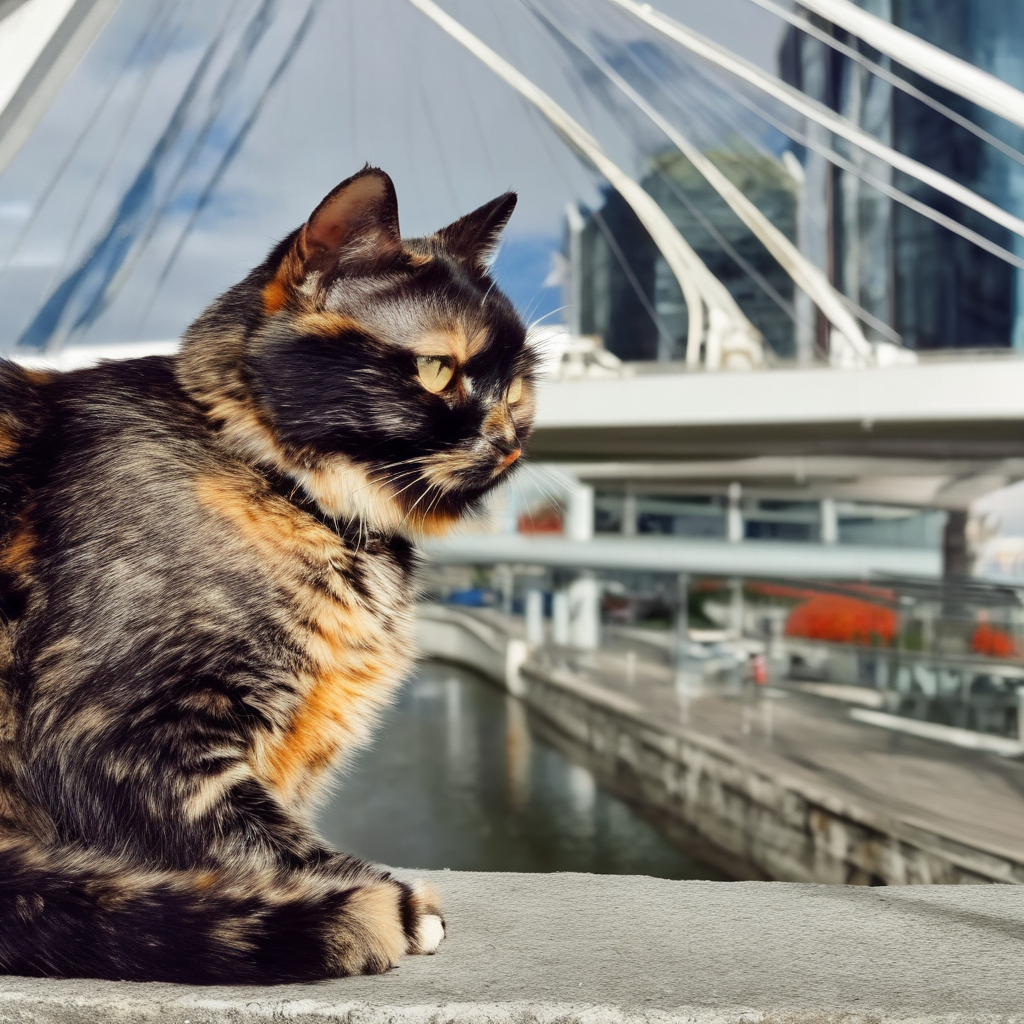

In [8]:
image = pipe("A realistic photo of my Elsa in front of the Samuel Beckett bridge in Dublin, Ireland", num_inference_steps=75).images[0]

image